In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

In [2]:
# Cargar un conjunto de datos
df = pd.read_csv('out2.csv')

X = df['text']
y = df['labels']  # Etiqueta objetivo

In [3]:
# Usar TfidfVectorizer
#######################

def custom_tokenizer(text):
    # Split the text by spaces, treating each space-separated part as a word
    return text.split(' ')

vectorizer = TfidfVectorizer(min_df=2, tokenizer=custom_tokenizer)
#vectorizer = TfidfVectorizer(min_df=3, max_df=.3)

X_vectorized = vectorizer.fit_transform(X)
print(f'Tamaño de X_vectorized: {X_vectorized.shape}')

# Dividir los datos en entrenamiento y prueba
X_train, X_valid, y_train, y_valid = train_test_split(X_vectorized, y, test_size=0.15, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.4, stratify=y_valid, random_state=42)

## Usar SMOTE para balancear las clases
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Tamaño de X_vectorized: (44523, 9509)


Exportar vectorizador

In [ ]:
!pip install dill
import dill as dl
file = open("vectorizer.pkl", "wb")
dl.dump(vectorizer, file)
file.close()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.3 MB/s eta 0:00:00


## NaiveBayes

In [ ]:
# Crear el modelo Naive Bayes
model = MultinomialNB(alpha=.4)  # Ajusta el parámetro alpha si es necesario

## Entrenar el modelo
model.fit(X_train_balanced, y_train_balanced)
# model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_valid)

# Evaluar el modelo
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Reporte de clasificación
print(classification_report(y_valid, y_pred))

Accuracy: 49.04%
              precision    recall  f1-score   support

           0       0.30      0.40      0.34       438
           1       0.12      0.35      0.18        52
           2       0.15      0.38      0.22        56
           3       0.76      0.63      0.69      1537
           4       0.53      0.40      0.45      1299
           5       0.33      0.50      0.40       234
           6       0.29      0.41      0.34       391

    accuracy                           0.49      4007
   macro avg       0.36      0.44      0.37      4007
weighted avg       0.55      0.49      0.51      4007



## *Word2Vec* (Google)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Ruta al archivo en tu Google Drive
model_path = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin'

from gensim.models import KeyedVectors
model_w2v = KeyedVectors.load_word2vec_format(model_path, binary=True)


Mounted at /content/drive


In [ ]:
def get_average_vector(tokens, model, vector_size=300):
    vectors = []
    for word in tokens:
        if word in model:  # Acceder al modelo directamente
            vectors.append(model[word])  # El diccionario de palabras está directamente en 'model'
    if len(vectors) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(vectors, axis=0)

# Tokenizar el texto en 'df['text']'
df['tokens'] = df['text'].apply(lambda x: x.split())

# Obtener vectores promediados para los documentos
X_vectors = np.array([get_average_vector(tokens, model_w2v) for tokens in df['tokens']])


### Naive Bayes

In [ ]:
# Escalamos, para que todos los valores sean positivos
X_vectors = X_vectors + abs(X_vectors.min())

# Dividir los datos en entrenamiento y prueba
X_train_w2v, X_valid_w2v, y_train_w2v, y_valid_w2v = train_test_split(X_vectors, y, test_size=0.15, random_state=42)
X_valid_w2v, X_test_w2v, y_valid_w2v, y_test_w2v = train_test_split(X_valid_w2v, y_valid_w2v, test_size=0.4, stratify=y_valid_w2v, random_state=42)

# Crear el modelo Naive Bayes
model = MultinomialNB(alpha=.4)  # Ajusta el parámetro alpha si es necesario

## Usar SMOTE para balancear las clases
smote = SMOTE()
X_train_balanced_w2v, y_train_balanced_w2v = smote.fit_resample(X_train_w2v, y_train_w2v)

## Entrenar el modelo
model.fit(X_train_balanced_w2v, y_train_balanced_w2v)
# model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_valid_w2v)

# Evaluar el modelo
accuracy = accuracy_score(y_valid_w2v, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Reporte de clasificación
print(classification_report(y_valid_w2v, y_pred))

Accuracy: 40.00%
              precision    recall  f1-score   support

           0       0.28      0.32      0.30       436
           1       0.07      0.33      0.11        46
           2       0.06      0.17      0.09        59
           3       0.77      0.43      0.55      1565
           4       0.46      0.48      0.47      1282
           5       0.14      0.27      0.19       227
           6       0.21      0.25      0.23       392

    accuracy                           0.40      4007
   macro avg       0.28      0.32      0.28      4007
weighted avg       0.51      0.40      0.43      4007



Observamos que los resultados con Word2Vec son sustancialmente peores. De aquí en adelante se emplea TfidfVectorizer.

## Regresion

Podemos usar penalización lasso (l1) o Ridge (l2)

In [4]:
# Crear y entrenar el modelo Logistic Regression
model = LogisticRegression(max_iter=250, C=1.3, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_valid)

# Evaluar el modelo
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Reporte de clasificación
print(classification_report(y_valid, y_pred))


Accuracy: 65.46%
              precision    recall  f1-score   support

           0       0.53      0.31      0.39       438
           1       0.75      0.35      0.47        52
           2       0.68      0.45      0.54        56
           3       0.79      0.79      0.79      1537
           4       0.56      0.77      0.65      1299
           5       0.70      0.48      0.57       234
           6       0.59      0.28      0.38       391

    accuracy                           0.65      4007
   macro avg       0.66      0.49      0.54      4007
weighted avg       0.66      0.65      0.64      4007



Exporting with pickle

In [ ]:
import pickle as pkl
file = open("regression.pkl", "wb")
pkl.dump(model, file)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# Crear y entrenar el modelo Logistic Regression
model = LogisticRegressionCV(max_iter=250, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_valid)

# Evaluar el modelo
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Reporte de clasificación
print(classification_report(y_valid, y_pred))

Accuracy: 64.19%
              precision    recall  f1-score   support

           0       0.46      0.32      0.38       438
           1       0.65      0.33      0.44        52
           2       0.60      0.45      0.51        56
           3       0.78      0.79      0.78      1537
           4       0.56      0.74      0.64      1299
           5       0.68      0.48      0.56       234
           6       0.59      0.24      0.34       391

    accuracy                           0.64      4007
   macro avg       0.61      0.48      0.52      4007
weighted avg       0.64      0.64      0.63      4007



Se emplea el clasificador con CV (Validacion Cruzada) para que auto ajuste el valor de penalización C.

In [ ]:
# Definir los parámetros que quieres probar
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'max_iter': [250, 500, 1000, 1500],
    },
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['saga'],
        'max_iter': [250, 500, 1000, 1500],
    },
    {
        'penalty': ['l2'],  # Only 'l2' penalty for 'lbfgs' and 'newton-cg'
        'solver': ['lbfgs', 'newton-cg'],
        'max_iter': [250, 500, 1000, 1500],
    }
]


# Crear el modelo de regresión logística
model = LogisticRegressionCV()

# Realizar la búsqueda de hiperparámetros; al usar la versión CV, se calibra internamente la penalización C.

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Ver los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")

## kNN

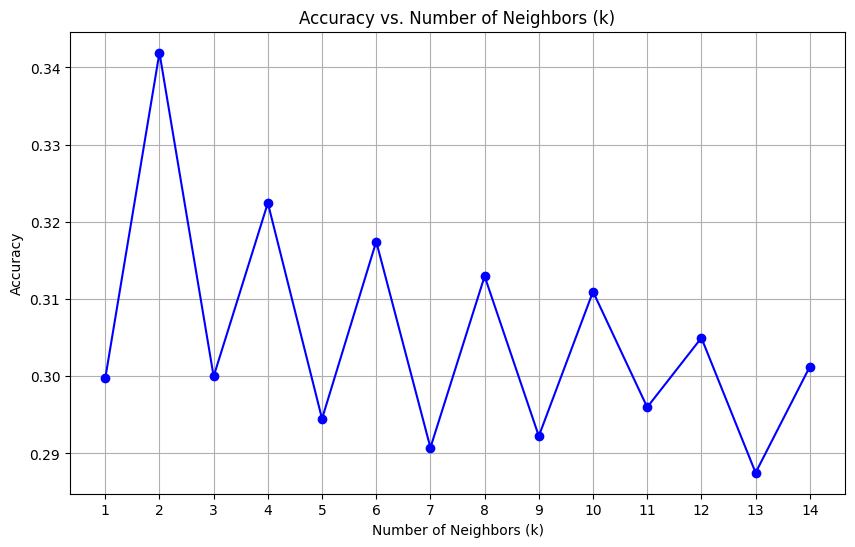

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neighbor_range = range(1, 15)  # Test values from 1 to 20
accuracies = []

# Iterate over n_neighbors
for k in neighbor_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_balanced, y_train_balanced)
    y_pred = knn.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    accuracies.append(acc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(neighbor_range, accuracies, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(neighbor_range)
plt.grid()
plt.show()

## Clasificador binario

In [ ]:
# Entrenamiento del modelo de árbol de decisión multietiqueta
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predicciones
y_pred = classifier.predict(X_valid)

# Evaluación del modelo
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.31      0.33       438
           1       0.32      0.29      0.30        52
           2       0.51      0.32      0.40        56
           3       0.69      0.70      0.70      1537
           4       0.51      0.57      0.54      1299
           5       0.46      0.36      0.41       234
           6       0.30      0.26      0.28       391

    accuracy                           0.54      4007
   macro avg       0.45      0.40      0.42      4007
weighted avg       0.54      0.54      0.54      4007



## Passive-Aggressive

Los Passive-Aggressive Classifiers son modelos eficientes y rápidos, ideales para escenarios de aprendizaje en línea y donde los datos están en constante cambio. Son especialmente útiles cuando necesitas clasificar grandes cantidades de datos de manera continua y adaptativa, como en clasificación de texto o flujos de datos en tiempo real. Sin embargo, no son adecuados para problemas no lineales y requieren ajustes cuidadosos del parámetro C para obtener buenos resultados.

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

# Crear y entrenar el clasificador
clf = PassiveAggressiveClassifier(max_iter=1000, random_state=41, C=0.002, loss = "squared_hinge")
clf.fit(X_train, y_train)

# Realizar predicciones
y_pred = clf.predict(X_valid)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Accuracy: 0.644871474918892
              precision    recall  f1-score   support

           0       0.49      0.30      0.37       438
           1       0.79      0.37      0.50        52
           2       0.73      0.39      0.51        56
           3       0.78      0.80      0.79      1537
           4       0.55      0.76      0.64      1299
           5       0.70      0.43      0.53       234
           6       0.59      0.27      0.37       391

    accuracy                           0.64      4007
   macro avg       0.66      0.47      0.53      4007
weighted avg       0.65      0.64      0.63      4007



## VSM

In [ ]:
from sklearn.svm import SVC

mi_svc = SVC(kernel='rbf')
mi_svc.fit(X_train, y_train)

# Predicciones
y_pred = mi_svc.predict(X_valid)

# Evaluación del modelo
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Accuracy: 0.6441227851260295
              precision    recall  f1-score   support

           0       0.57      0.26      0.35       438
           1       0.74      0.33      0.45        52
           2       0.71      0.30      0.42        56
           3       0.81      0.76      0.78      1537
           4       0.53      0.83      0.65      1299
           5       0.71      0.41      0.52       234
           6       0.65      0.22      0.33       391

    accuracy                           0.64      4007
   macro avg       0.67      0.44      0.50      4007
weighted avg       0.67      0.64      0.62      4007



In [ ]:
from sklearn.svm import SVC

mi_svc = SVC(kernel='sigmoid')
mi_svc.fit(X_train, y_train)

# Predicciones
y_pred = mi_svc.predict(X_valid)

# Evaluación del modelo
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Accuracy: 0.6336411280259546
              precision    recall  f1-score   support

           0       0.49      0.29      0.36       438
           1       0.67      0.35      0.46        52
           2       0.59      0.46      0.52        56
           3       0.78      0.76      0.77      1537
           4       0.54      0.77      0.63      1299
           5       0.64      0.45      0.53       234
           6       0.60      0.25      0.35       391

    accuracy                           0.63      4007
   macro avg       0.62      0.48      0.52      4007
weighted avg       0.64      0.63      0.62      4007



In [ ]:
from sklearn.svm import SVC

mi_svc = SVC(kernel='linear')
mi_svc.fit(X_train, y_train)

# Predicciones
y_pred = mi_svc.predict(X_valid)

# Evaluación del modelo
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Accuracy: 0.6446219116546045
              precision    recall  f1-score   support

           0       0.50      0.29      0.37       438
           1       0.65      0.33      0.44        52
           2       0.55      0.46      0.50        56
           3       0.80      0.77      0.78      1537
           4       0.55      0.79      0.65      1299
           5       0.66      0.47      0.55       234
           6       0.62      0.24      0.35       391

    accuracy                           0.64      4007
   macro avg       0.62      0.48      0.52      4007
weighted avg       0.65      0.64      0.63      4007



In [ ]:
# Ajuste de parámetros mediante GridSearch
param_grid = {
    'C': [0.1, 1, 10],  # Valores de C a probar
    'gamma': ['scale', 'auto', 0.1, 1]  # Valores de gamma
}

grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntuación de validación:", grid_search.best_score_)

## OneVsRest

Un **One-vs-Rest Classifier** (OvR), también conocido como **One-vs-All**, es una estrategia que transforma un problema de clasificación multiclase o multietiqueta en varios problemas de clasificación binaria, donde cada clase (o etiqueta) se trata por separado.

### ¿Cómo funciona?

Para cada clase \( c_i \) en el conjunto de clases \( C = \{c_1, c_2, ..., c_n\} \):
   - Se entrena un modelo binario que distingue entre:
     - \( c_i \): Los ejemplos positivos.
     - \( \neg c_i \): Los ejemplos negativos (todas las demás clases combinadas).

### Ojo, algunos clasificadores ya usan OvR internamente, por ejemplo, los VSM

El kNN no funcionó bien con ovr (daba 24%)


### NB

In [ ]:
# Entrenamiento del modelo de árbol de decisión multietiqueta
classifier = OneVsRestClassifier(MultinomialNB(alpha=.4))
classifier.fit(X_train_balanced, y_train_balanced)

# Predicciones
y_pred = classifier.predict(X_valid)

# Evaluación del modelo
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Accuracy: 0.4946343898178188
              precision    recall  f1-score   support

           0       0.31      0.42      0.36       438
           1       0.14      0.40      0.20        52
           2       0.20      0.61      0.30        56
           3       0.76      0.64      0.70      1537
           4       0.53      0.36      0.43      1299
           5       0.34      0.55      0.42       234
           6       0.30      0.39      0.34       391

    accuracy                           0.49      4007
   macro avg       0.37      0.48      0.39      4007
weighted avg       0.55      0.49      0.51      4007



### DecisionTree

In [ ]:
# Entrenamiento del modelo de árbol de decisión multietiqueta
classifier = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
classifier.fit(X_train_balanced, y_train_balanced)

# Predicciones
y_pred = classifier.predict(X_valid)

# Evaluación del modelo
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Accuracy: 0.44372348390316946
              precision    recall  f1-score   support

           0       0.41      0.19      0.26       438
           1       0.47      0.31      0.37        52
           2       0.62      0.38      0.47        56
           3       0.79      0.54      0.64      1537
           4       0.49      0.36      0.42      1299
           5       0.46      0.47      0.46       234
           6       0.17      0.65      0.27       391

    accuracy                           0.44      4007
   macro avg       0.49      0.41      0.41      4007
weighted avg       0.56      0.44      0.47      4007



### Passive-Aggressive

In [ ]:
classifier = OneVsRestClassifier(PassiveAggressiveClassifier(max_iter=1000, random_state=41, C=0.002, loss = "squared_hinge"))
classifier.fit(X_train_balanced, y_train_balanced)

# Predicciones
y_pred = classifier.predict(X_valid)

# Evaluación del modelo
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))


Accuracy: 0.5934614424756676
              precision    recall  f1-score   support

           0       0.38      0.48      0.43       438
           1       0.28      0.52      0.36        52
           2       0.37      0.66      0.48        56
           3       0.83      0.71      0.77      1537
           4       0.61      0.52      0.56      1299
           5       0.48      0.60      0.53       234
           6       0.36      0.50      0.42       391

    accuracy                           0.59      4007
   macro avg       0.47      0.57      0.51      4007
weighted avg       0.63      0.59      0.61      4007



## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Crear el modelo de Random Forest
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42)

# Entrenar el modelo
rf_clf.fit(X_train, y_train)

# Hacer predicciones
y_pred = rf_clf.predict(X_valid)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Accuracy: 0.635388070875967
              precision    recall  f1-score   support

           0       0.65      0.20      0.31       438
           1       0.72      0.25      0.37        52
           2       0.86      0.21      0.34        56
           3       0.74      0.79      0.76      1537
           4       0.53      0.82      0.65      1299
           5       0.81      0.35      0.49       234
           6       0.73      0.17      0.27       391

    accuracy                           0.64      4007
   macro avg       0.72      0.40      0.46      4007
weighted avg       0.67      0.64      0.60      4007



## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# Initialize AdaBoost with DecisionTreeClassifier as the base estimator
adaboost_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Weak classifier (decision stump)
    n_estimators=2000,                                    # Number of weak classifiers
    learning_rate=1.0                                   # Learning rate
)

# Train the model
adaboost_clf.fit(X_train, y_train)

# Make predictions
y_pred = adaboost_clf.predict(X_valid)

print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Accuracy: 0.5455452957324681
              precision    recall  f1-score   support

           0       0.69      0.11      0.20       438
           1       1.00      0.02      0.04        52
           2       1.00      0.02      0.04        56
           3       0.77      0.56      0.65      1537
           4       0.44      0.93      0.60      1299
           5       0.87      0.25      0.39       234
           6       0.82      0.02      0.04       391

    accuracy                           0.55      4007
   macro avg       0.80      0.27      0.28      4007
weighted avg       0.67      0.55      0.49      4007



## XGBoost

In [ ]:
!pip install xgboost

from xgboost import XGBClassifier

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(
    n_estimators=100,    # Number of trees
    max_depth=5,         # Maximum depth of trees
    learning_rate=0.1,   # Learning rate
    use_label_encoder=False,  # Avoid warnings for label encoding
    eval_metric='logloss'     # Specify evaluation metric
)

# Train the model
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_valid)

print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:47:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6313950586473671
              precision    recall  f1-score   support

           0       0.64      0.22      0.32       438
           1       0.68      0.29      0.41        52
           2       0.72      0.38      0.49        56
           3       0.84      0.69      0.75      1537
           4       0.51      0.88      0.64      1299
           5       0.73      0.42      0.54       234
           6       0.62      0.26      0.37       391

    accuracy                           0.63      4007
   macro avg       0.68      0.45      0.50      4007
weighted avg       0.68      0.63      0.61      4007



## Ensemble con votación

In [ ]:
from sklearn.ensemble import VotingClassifier

# Define classifiers
clf1 = LogisticRegression(max_iter=250, C=1.3, penalty='l1', solver='liblinear')
clf2 = PassiveAggressiveClassifier(max_iter=1000, random_state=41, C=0.002, loss = "squared_hinge")
clf3 = SVC(probability=True, kernel='linear')

# Create ensemble classifier
ensemble = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
ensemble.fit(X_train, y_train)

# Evaluate
y_pred = ensemble.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Accuracy: 0.6481157973546294
              precision    recall  f1-score   support

           0       0.50      0.30      0.38       438
           1       0.72      0.35      0.47        52
           2       0.63      0.39      0.48        56
           3       0.79      0.79      0.79      1537
           4       0.55      0.77      0.64      1299
           5       0.70      0.45      0.55       234
           6       0.59      0.26      0.36       391

    accuracy                           0.65      4007
   macro avg       0.64      0.47      0.52      4007
weighted avg       0.65      0.65      0.63      4007



## Perceptron


In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(128, 64), random_state=1, max_iter=300).fit(X_train, y_train)

predict = clf.predict(X_valid)
print(classification_report(y_valid, predict))